<a href="https://colab.research.google.com/github/LayanAlrashoud/Alzheimer-s-disease-Misk-Samsung/blob/master/alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Alzheimer_Dataset_V2.zip"   # path to data
extract_path = "/content/Alzheimer_Dataset_V2"                 # where to unzip

# Create folder if not exists
os.makedirs(extract_path, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)

Unzipped to: /content/Alzheimer_Dataset_V2


## Preprocessing

In [6]:
! pip install kagglehub

In [7]:
# === Cell 0 ===
# Robust dataset locator: finds Alzheimer_Dataset_V2/train even after a session reset.
from pathlib import Path
import os

def get_data_root():

    bases = [
        Path.home() / ".cache" / "kagglehub" / "datasets" / "ashrafulhossenakash" / "alzheimer-disease-dataset",
        Path("/root/.cache/kagglehub/datasets/ashrafulhossenakash/alzheimer-disease-dataset"),
    ]

    for base in bases:
        if base.exists():
            for p in base.glob("versions/*/Alzheimer_Dataset_V2"):
                if (p / "train").exists():
                    return p
            for p in base.glob("versions/*"):
                if (p / "train").exists() and (p / "val").exists() and (p / "test").exists():
                    return p


    env_root = os.environ.get("ALZ_DATA_ROOT")
    if env_root and (Path(env_root) / "train").exists():
        return Path(env_root)


    try:
        import kagglehub
        dl_path = kagglehub.dataset_download("ashrafulhossenakash/alzheimer-disease-dataset")
        dl = Path(dl_path)
        v2 = dl / "Alzheimer_Dataset_V2"
        if (v2 / "train").exists():
            return v2
        for p in dl.rglob("Alzheimer_Dataset_V2"):
            if (p / "train").exists():
                return p
        if (dl / "train").exists() and (dl / "val").exists() and (dl / "test").exists():
            return dl
    except Exception as e:
        pass

    raise FileNotFoundError(
        "Could not locate the dataset. Set ALZ_DATA_ROOT to the folder that contains 'train/ val/ test/'."
    )

DATA_ROOT = get_data_root()
print("DATA_ROOT ->", DATA_ROOT)
print("Has train? ", (DATA_ROOT/'train').exists())


Using Colab cache for faster access to the 'alzheimer-disease-dataset' dataset.
DATA_ROOT -> /kaggle/input/alzheimer-disease-dataset/Alzheimer_Dataset_V2
Has train?  True


TRAIN counts (before):
  MildDemented: 6272
  ModerateDemented: 4524
  NonDemented: 6720
  VeryMildDemented: 6272
  Total: 23788


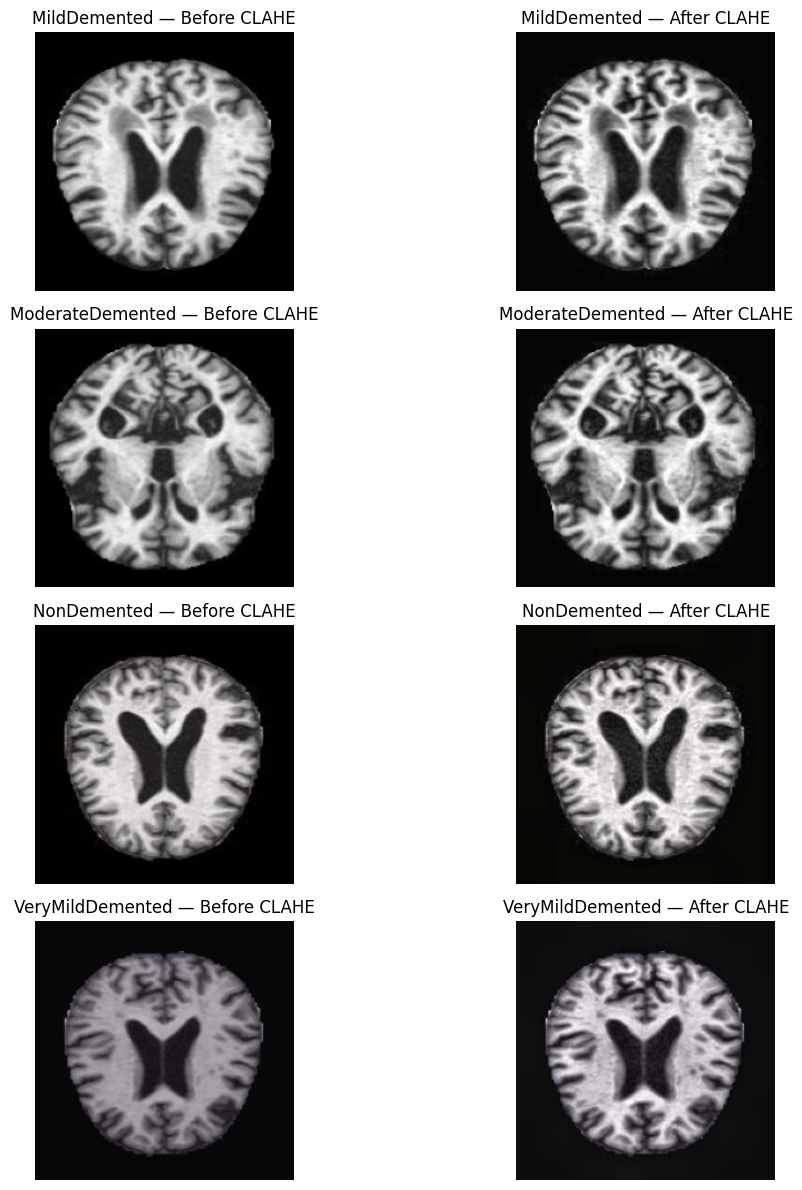

In [8]:
# === Cell 1 ===
# Setup + count + show before/after enhancement

import os, random, shutil
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
\

DATA_ROOT = DATA_ROOT = DATA_ROOT


TRAIN_DIR = DATA_ROOT / "train"
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def list_images(folder: Path):
    return [f for f in os.listdir(folder) if f.lower().endswith(IMG_EXTS)]

def count_split(split_dir: Path):
    counts = {}
    for cls in sorted(os.listdir(split_dir)):
        cpath = split_dir / cls
        if cpath.is_dir():
            counts[cls] = len(list_images(cpath))
    return counts

import cv2

class ApplyCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img: Image.Image) -> Image.Image:
        arr = np.array(img)
        if arr.ndim == 2:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            out = clahe.apply(arr)
            return Image.fromarray(out)
        elif arr.ndim == 3:
            lab = cv2.cvtColor(arr, cv2.COLOR_RGB2LAB)
            L, A, B = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            L2 = clahe.apply(L)
            lab2 = cv2.merge((L2, A, B))
            rgb2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
            return Image.fromarray(rgb2)
        return img

enhancer = ApplyCLAHE()

counts_before = count_split(TRAIN_DIR)
print("TRAIN counts (before):")
for k, v in counts_before.items():
    print(f"  {k}: {v}")
print("  Total:", sum(counts_before.values()))

classes = sorted(list(counts_before.keys()))
n = len(classes)
plt.figure(figsize=(12, 3*n))
for i, cls in enumerate(classes):
    cpath = TRAIN_DIR / cls
    files = list_images(cpath)
    if not files:
        continue
    img_path = cpath / random.choice(files)
    original = Image.open(img_path).convert("RGB")
    # Enhancement -> Resize (224,224)
    before = original.resize((224,224))
    after  = enhancer(before)

    plt.subplot(n, 2, 2*i+1)
    plt.imshow(before)
    plt.title(f"{cls} — Before CLAHE")
    plt.axis("off")

    plt.subplot(n, 2, 2*i+2)
    plt.imshow(after)
    plt.title(f"{cls} — After CLAHE")
    plt.axis("off")

plt.tight_layout()
plt.show()


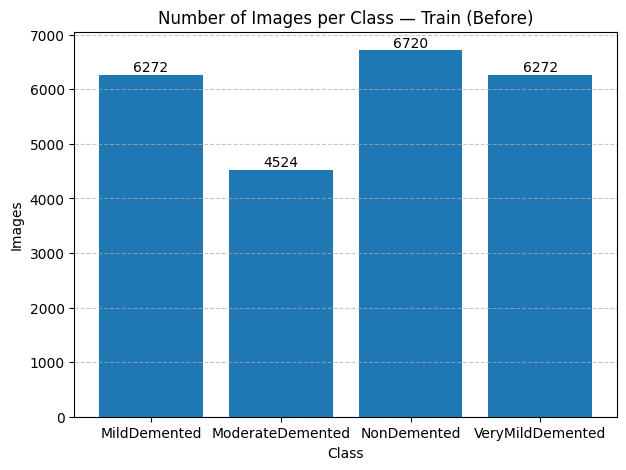

In [9]:
# === Cell 2 ===
# Bar chart of train counts BEFORE augmentation

import matplotlib.pyplot as plt

classes = list(counts_before.keys())
values  = [counts_before[c] for c in classes]

plt.figure(figsize=(7,5))
plt.bar(classes, values)
plt.title("Number of Images per Class — Train (Before)")
plt.xlabel("Class")
plt.ylabel("Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.show()


In [10]:
# === Cell 3 ===
# Build a balanced train set using enhanced images (CLAHE + Resize) for augmentation


from torchvision import transforms
import random

BALANCED_ROOT = Path("./train_balanced")  # الناتج
BALANCED_ROOT.mkdir(parents=True, exist_ok=True)

TARGET_CLASS = "ModerateDemented"
resize_to = (224, 224)

augment = transforms.Compose([
    transforms.RandomApply([transforms.ElasticTransform(alpha=50.0)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3)], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
])

target_count = max(counts_before.values())
print("Target count for balancing:", target_count)

def symlink_or_copy(src: Path, dst: Path):
    try:
        if dst.exists():
            return
        os.symlink(src, dst)
    except OSError:
        if not dst.exists():
            shutil.copy2(src, dst)

for cls in counts_before.keys():
    src_cls = TRAIN_DIR / cls
    dst_cls = BALANCED_ROOT / cls
    dst_cls.mkdir(exist_ok=True, parents=True)

    files = [f for f in list_images(src_cls)]
    for f in files:
        src = src_cls / f
        dst = dst_cls / f
        symlink_or_copy(src, dst)

src_cls = TRAIN_DIR / TARGET_CLASS
dst_cls = BALANCED_ROOT / TARGET_CLASS
dst_cls.mkdir(exist_ok=True, parents=True)

current_files = [f for f in os.listdir(dst_cls) if f.lower().endswith(IMG_EXTS)]
current_count = len(current_files)

if current_count > target_count:
    keep = set(random.sample(current_files, target_count))
    for f in current_files:
        if f not in keep:
            try:
                os.remove(dst_cls / f)
            except FileNotFoundError:
                pass
    print(f"[Trimmed] {TARGET_CLASS}: kept {target_count}, removed {current_count - target_count}")
    current_count = target_count

elif current_count < target_count:
    base_files = [f for f in list_images(src_cls)]
    i = 0
    while current_count < target_count and base_files:
        f = random.choice(base_files)
        img = Image.open(src_cls / f).convert("RGB")
        # Enhancement -> Resize -> Augmentation
        img_enh = enhancer(img.resize(resize_to))
        img_aug = augment(img_enh)
        out_name = f"aug_{i:06d}.jpg"
        out_path = dst_cls / out_name
        while out_path.exists():
            i += 1
            out_name = f"aug_{i:06d}.jpg"
            out_path = dst_cls / out_name
        img_aug.save(out_path, format="JPEG", quality=95)
        i += 1
        current_count += 1

    print(f"[Augmented] {TARGET_CLASS}: now {current_count} images (target {target_count})")
else:
    print(f"[Balanced] {TARGET_CLASS} already at target: {target_count}")


Target count for balancing: 6720
[Augmented] ModerateDemented: now 6720 images (target 6720)


TRAIN counts (after):
  MildDemented: 6272
  ModerateDemented: 6720
  NonDemented: 6720
  VeryMildDemented: 6272
  Total: 25984


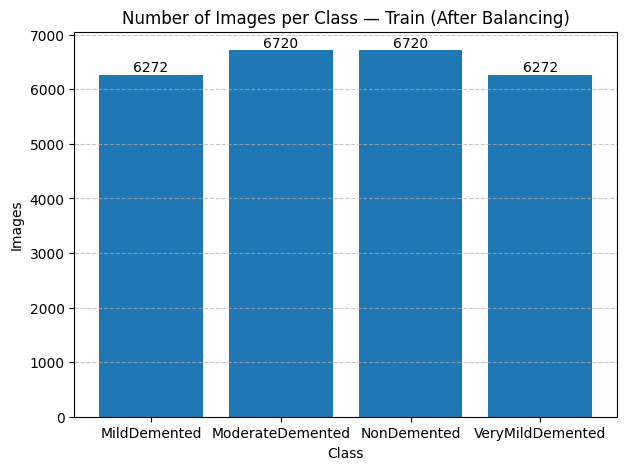

In [11]:
# === Cell 4 ===
# Count AFTER balancing + final bar chart

def count_split(path: Path):
    counts = {}
    for cls in sorted(os.listdir(path)):
        cpath = path / cls
        if cpath.is_dir():
            counts[cls] = len([f for f in os.listdir(cpath) if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))])
    return counts

counts_after = count_split(BALANCED_ROOT)

print("TRAIN counts (after):")
for k, v in counts_after.items():
    print(f"  {k}: {v}")
print("  Total:", sum(counts_after.values()))


import matplotlib.pyplot as plt

classes = list(counts_after.keys())
values  = [counts_after[c] for c in classes]

plt.figure(figsize=(7,5))
plt.bar(classes, values)
plt.title("Number of Images per Class — Train (After Balancing)")
plt.xlabel("Class")
plt.ylabel("Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.show()


In [12]:
# === Cell 5 ===

from pathlib import Path
import shutil
from PIL import Image
from tqdm import tqdm

READY_ROOT = Path("./alzheimers_dataset")
(READY_ROOT/"train_final").mkdir(parents=True, exist_ok=True)
(READY_ROOT/"val_final").mkdir(parents=True, exist_ok=True)
(READY_ROOT/"test_final").mkdir(parents=True, exist_ok=True)

if (READY_ROOT/"train_final").exists():
    shutil.rmtree(READY_ROOT/"train_final")
shutil.copytree(BALANCED_ROOT, READY_ROOT/"train_final")

def prepare_split(src_dir, dst_dir):
    if dst_dir.exists():
        shutil.rmtree(dst_dir)
    dst_dir.mkdir(parents=True, exist_ok=True)
    for cls in os.listdir(src_dir):
        src_cls = Path(src_dir)/cls
        dst_cls = dst_dir/cls
        dst_cls.mkdir(parents=True, exist_ok=True)
        for f in tqdm(list_images(src_cls), desc=f"Processing {cls}"):
            img = Image.open(src_cls/f).convert("RGB")
            img = enhancer(img.resize((224,224)))
            img.save(dst_cls/f, format="JPEG", quality=95)

prepare_split(DATA_ROOT/"val", READY_ROOT/"val_final")
prepare_split(DATA_ROOT/"test", READY_ROOT/"test_final")

print("alzheimers_dataset")
print(" - train_final (Balanced, Augmented)")
print(" - val_final   (Enhanced only)")
print(" - test_final  (Enhanced only)")



Processing MildDemented: 100%|██████████| 1344/1344 [00:12<00:00, 106.98it/s]

alzheimers_dataset
 - train_final (Balanced, Augmented)
 - val_final   (Enhanced only)
 - test_final  (Enhanced only)


In [51]:
"""
Lyane's comment

What has been done?

Original dataset: Downloaded the Alzheimer Disease Dataset V2.

Enhancement: Applied CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve brightness/contrast.

Resize: All images were resized to a fixed size of 224×224.

Augmentation: Applied augmentation (Elastic, ColorJitter, Horizontal Flip, Rotation) only to the ModerateDemented class to balance it with the other classes.

Balancing: All classes in the train set now have the same number of images (balanced).

Final splits created:

train_final/ → Enhanced + Augmented (balanced)

val_final/ → Enhanced only (no augmentation)

test_final/ → Enhanced only (no augmentation)

 How to use the dataset?

***********Use only this folder: alzheimers_dataset/********

It contains three subfolders:

train_final

val_final

test_final

"""

"\nLyane's comment\n\nWhat has been done?\n\nOriginal dataset: Downloaded the Alzheimer Disease Dataset V2.\n\nEnhancement: Applied CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve brightness/contrast.\n\nResize: All images were resized to a fixed size of 224×224.\n\nAugmentation: Applied augmentation (Elastic, ColorJitter, Horizontal Flip, Rotation) only to the ModerateDemented class to balance it with the other classes.\n\nBalancing: All classes in the train set now have the same number of images (balanced).\n\nFinal splits created:\n\ntrain_final/ → Enhanced + Augmented (balanced)\n\nval_final/ → Enhanced only (no augmentation)\n\ntest_final/ → Enhanced only (no augmentation)\n\n How to use the dataset?\n\n***********Use only this folder: alzheimers_dataset/********\n\nIt contains three subfolders:\n\ntrain_final\n\nval_final\n\ntest_final\n\n"

## Part 2: Preprocessing

In [13]:
# ====================================================================
# SECTION 2: Data Preprocessing
# This section defines the transformations and loads the dataset.
# The goal is to prepare the image data to be fed into the model.
# All transformations are applied "on-the-fly" to batches of data.
# ====================================================================

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 2.1 Define the Preprocessing Pipeline
# PyTorch will apply these to every image loaded.
data_transform = transforms.Compose([

    # Resize: Ensures all images have a consistent size for the model.
    # The new size is 224x224 pixels.
    transforms.Resize((224, 224)),

    # Grayscale Conversion: Our MRI images are grayscale, not color.
    # This converts the images to a single channel, which is more
    # memory-efficient and correct for our data.
    transforms.Grayscale(num_output_channels=1),

    # Convert to Tensor: This is the most important step. It converts
    # the image (a set of pixels) into a PyTorch tensor (a numerical array)
    # that the neural network can process. It also scales pixel values to [0, 1].
    transforms.ToTensor(),

    # Normalization: Standardizes the tensor's pixel values.
    # The mean and standard deviation are set for a grayscale image.
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print(" The data preprocessing pipeline has been successfully defined.")

# 2.2 Load the Dataset
# We use PyTorch's ImageFolder class, which is perfect for our folder structure.
# It automatically reads the images and assigns labels based on the folder names.

# The path to our training data
data_path = 'alzheimers_dataset/train_final/'

# Create a dataset object.
train_dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

# Create a DataLoader. This will load the data in batches and handle
# shuffling and parallel processing, which is critical for training.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f" Training dataset loaded. It contains {len(train_dataset)} images.")
print(" DataLoader created successfully, ready to deliver batches for training.")

# 2.3 Verification
# We load a single batch to confirm the transformations were applied correctly.
# The printed shape and data type prove that the data is now in the correct format.

# Loading the first batch of images and labels
images, labels = next(iter(train_loader))

# Print the tensor details
print("\n--- Verification of Preprocessed Data ---")
print(f" Processed tensor shape: {images.shape}")
print(f" Processed tensor data type: {images.dtype}")
print(f" Number of classes found: {len(train_dataset.classes)}")
print(f" Labels in the first batch: {labels}")

 The data preprocessing pipeline has been successfully defined.
 Training dataset loaded. It contains 25984 images.
 DataLoader created successfully, ready to deliver batches for training.

--- Verification of Preprocessed Data ---
 Processed tensor shape: torch.Size([32, 1, 224, 224])
 Processed tensor data type: torch.float32
 Number of classes found: 4
 Labels in the first batch: tensor([0, 2, 1, 0, 2, 1, 1, 2, 3, 2, 1, 2, 1, 2, 0, 3, 1, 0, 2, 1, 2, 1, 0, 2,
        3, 1, 3, 1, 0, 2, 1, 1])


## EffecientNet Model

In [14]:
# ------- Cell A:  model-specific imports ----------

# ML imports
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.cuda.amp import autocast, GradScaler
from torch.optim.swa_utils import AveragedModel, update_bn

from sklearn.metrics import (accuracy_score, f1_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, average_precision_score,
                             cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score)
from sklearn.preprocessing import label_binarize
import numpy as np, time, math, matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass


In [15]:
# ------- Cell B: config & hyperparams (tweak batch if on CPU) ----------
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)

# Two-stage training (small img, then native size)
STAGES = [
    dict(img=160, epochs=7, max_lr=1e-3, freeze=True),
    dict(img=224, epochs=3, max_lr=3e-4, freeze=False),
]

BATCH = 64 if device.type == "cuda" else 16
NUM_WORKERS = 4 if device.type == "cuda" else 2

LABEL_SMOOTH   = 0.05
MIXUP_START_P  = 0.6
MIXUP_END_P    = 0.0
MIXUP_END_AT   = 0.7
MIXUP_ALPHA    = 0.2
USE_CUTMIX     = True
FOCAL_GAMMA    = 1.5

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


In [16]:
# ------- Cell C: transforms & loaders ----------
def make_transforms(img_size):
    return (
        transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.85, 1.0), ratio=(0.95, 1.05)),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, translate=(0.04, 0.04), scale=(0.95, 1.05)),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomAutocontrast(p=0.25),
            transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.25),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]),
        transforms.Compose([
            transforms.Resize(img_size + 16),
            transforms.CenterCrop(img_size),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
    )

def make_loaders(img_size, class_weights=None):
    train_tf, eval_tf = make_transforms(img_size)
    train_ds = datasets.ImageFolder(str(TRAIN_DIR), transform=train_tf)
    val_ds   = datasets.ImageFolder(str(VAL_DIR),   transform=eval_tf)
    test_ds  = datasets.ImageFolder(str(TEST_DIR),  transform=eval_tf)
    assert train_ds.classes == val_ds.classes == test_ds.classes

    targets = torch.tensor(train_ds.targets)
    if class_weights is None:
        counts = torch.bincount(targets, minlength=len(train_ds.classes)).float()
        class_weights = (counts.sum() / (len(counts) * counts)).to(torch.float)

    sample_weights = class_weights[targets]
    sampler = WeightedRandomSampler(weights=sample_weights.double(),
                                    num_samples=len(sample_weights),
                                    replacement=True)

    dl_args = dict(num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"),
                   persistent_workers=(NUM_WORKERS>0), prefetch_factor=2)
    train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, **dl_args)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH*2, shuffle=False, **dl_args)
    test_dl  = DataLoader(test_ds,  batch_size=BATCH*2, shuffle=False, **dl_args)
    return train_ds, val_ds, test_ds, train_dl, val_dl, test_dl, class_weights


In [17]:
# ------- Cell D:  model + losses +  EMA----------

def build_model(num_classes):
    m = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    return m

def set_trainable(model, freeze_early=True):
    for p in model.parameters(): p.requires_grad = True
    if freeze_early:
        for i in [0,1,2]:
            for p in model.features[i].parameters(): p.requires_grad = False

class EMA:
    def __init__(self, model, decay=0.997):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k,v in model.state_dict().items()
                       if torch.is_floating_point(v)}
    @torch.no_grad()
    def update(self, model):
        sd = model.state_dict()
        for k, v in self.shadow.items():
            v.mul_(self.decay).add_(sd[k], alpha=1 - self.decay)
    def load(self, model):
        sd = model.state_dict(); sd.update(self.shadow); model.load_state_dict(sd, strict=False)

class FocalCE(nn.Module):
    def __init__(self, alpha=None, gamma=FOCAL_GAMMA, label_smoothing=LABEL_SMOOTH):
        super().__init__()
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.alpha = None
        if alpha is not None:
            a = alpha.float(); self.alpha = a / a.sum()
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, weight=self.alpha,
                             label_smoothing=self.label_smoothing, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp_(1e-6, 1-1e-6)
        return ((1 - pt) ** self.gamma * ce).mean()


In [18]:
# ------- Cell E:MixUp/CutMix helpers ----------

def mixup(images, labels, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(images.size(0), device=images.device)
    mixed = lam*images + (1-lam)*images[idx]
    return mixed, labels, labels[idx], lam

def cutmix(images, labels, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    bs, _, H, W = images.size()
    idx = torch.randperm(bs, device=images.device)
    rx, ry = np.random.randint(W), np.random.randint(H)
    rw, rh = int(W*np.sqrt(1-lam)), int(H*np.sqrt(1-lam))
    x1, y1 = max(rx-rw//2,0), max(ry-rh//2,0)
    x2, y2 = min(rx+rw//2,W), min(ry+rh//2,H)
    images[:, :, y1:y2, x1:x2] = images[idx, :, y1:y2, x1:x2]
    lam = 1 - ((x2-x1)*(y2-y1)/(W*H))
    return images, labels, labels[idx], lam

def scheduled_mix_prob(step, total_steps, start=MIXUP_START_P, end=MIXUP_END_P, end_at=MIXUP_END_AT):
    t = min(step / max(1, int(total_steps * end_at)), 1.0)
    return float(start + (end - start) * t)


In [19]:
# ------- Cell F :  train/eval + TTA ----------
def train_one_epoch(model, loader, criterion, opt, sched, scaler, ema,
                    mix_state, step_scheduler_each_batch=True, use_swa=False, swa_lr=None):
    model.train()
    if use_swa and swa_lr is not None:
        for pg in opt.param_groups: pg['lr'] = swa_lr
    total, loss_sum, correct = 0, 0.0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)
        p_now = scheduled_mix_prob(mix_state['step'], mix_state['total']); mix_state['step'] += 1
        do_mix = (np.random.rand() < p_now)
        if do_mix and USE_CUTMIX and np.random.rand() < 0.5:
            x_m, y_a, y_b, lam = cutmix(x, y, alpha=1.0)
        elif do_mix:
            x_m, y_a, y_b, lam = mixup(x, y)
        opt.zero_grad(set_to_none=True)
        with autocast(enabled=(device.type=="cuda")):
            logits = model(x_m if do_mix else x)
            loss = lam*criterion(logits, y_a) + (1-lam)*criterion(logits, y_b) if do_mix else criterion(logits, y)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update()
        if sched is not None and step_scheduler_each_batch:
            sched.step()
        if ema is not None: ema.update(model)
        loss_sum += loss.item()*x.size(0)
        _, pred = logits.max(1); correct += (pred == (y_a if do_mix else y)).sum().item()
        total += x.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, loss_sum, correct = 0, 0.0, 0
    for x, y in loader:
        x = x.to(device).to(memory_format=torch.channels_last); y = y.to(device)
        logits = model(x); loss = criterion(logits, y)
        loss_sum += loss.item()*x.size(0)
        _, pred = logits.max(1); correct += (pred==y).sum().item(); total += x.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def collect_logits(model, loader):
    model.eval()
    outs, ys = [], []
    scales = [0.9, 1.0, 1.1]
    for x, y in loader:
        x = x.to(device).to(memory_format=torch.channels_last)
        H, W = x.shape[-2:]; logits = 0
        for s in scales:
            newH, newW = int(H*s), int(W*s)
            xx = F.interpolate(x, size=(newH, newW), mode='bilinear', align_corners=False)
            xx = F.interpolate(xx, size=(H, W), mode='bilinear', align_corners=False)
            for k in [0,1,2,3]:
                zz = torch.rot90(xx, k, dims=[2,3])
                logits += model(zz)
                logits += model(torch.flip(zz, dims=[3]))
        outs.append((logits/ (len(scales)*8)).cpu()); ys.append(y)
    return torch.cat(outs), torch.cat(ys)

def tune_logit_bias(logits_val, y_val, steps=np.linspace(-0.8,0.8,9), iters=2):
    b = np.zeros(logits_val.shape[1], dtype=np.float32)
    lv = logits_val.numpy(); yv = y_val.numpy()
    from sklearn.metrics import f1_score as _f1
    for _ in range(iters):
        for c in range(lv.shape[1]):
            best, bestf = b[c], -1
            for v in steps:
                tmp = lv + b; tmp[:, c] += v - b[c]
                pred = tmp.argmax(1)
                f1 = _f1(yv, pred, average='macro', zero_division=0)
                if f1 > bestf: bestf, best = f1, v
            b[c] = best
    return b


In [20]:
from pathlib import Path
import os

def _looks_like_root(p: Path) -> bool:
    return (
        (p / "train").exists() and (p / "val").exists() and (p / "test").exists()
    ) or (
        (p / "train_final").exists() and (p / "val_final").exists() and (p / "test_final").exists()
    )

def get_data_root() -> Path:
    candidates = [
        Path("/content/Alzheimer_Dataset_V2"),
        Path("/content/drive/MyDrive/Alzheimer_Dataset_V2"),
        Path("/content/Archive/Alzheimer_Dataset_V2"),
        Path.home() / ".cache" / "kagglehub" / "datasets" / "ashrafulhossenakash" / "alzheimer-disease-dataset",
        Path("/root/.cache/kagglehub/datasets/ashrafulhossenakash/alzheimer-disease-dataset"),
    ]
    for base in candidates:
        if _looks_like_root(base): return base
        sub = base / "Alzheimer_Dataset_V2"
        if _looks_like_root(sub): return sub
        if base.exists():
            for p in base.glob("versions/*/Alzheimer_Dataset_V2"):
                if _looks_like_root(p): return p
            for p in base.glob("versions/*"):
                if _looks_like_root(p): return p
    env_root = os.environ.get("ALZ_DATA_ROOT")
    if env_root and _looks_like_root(Path(env_root)):
        return Path(env_root)
    raise FileNotFoundError("Could not locate dataset.")

def pick_split(root: Path, name: str) -> Path:
    a = root / name
    b = root / f"{name}_final"
    if a.exists(): return a
    if b.exists(): return b
    raise FileNotFoundError(f"Missing split '{name}'.")

DATA_ROOT = get_data_root()
TRAIN_DIR = pick_split(DATA_ROOT, "train")
VAL_DIR   = pick_split(DATA_ROOT, "val")
TEST_DIR  = pick_split(DATA_ROOT, "test")

print("DATA_ROOT ->", DATA_ROOT)
print("TRAIN_DIR ->", TRAIN_DIR)
print("VAL_DIR   ->", VAL_DIR)
print("TEST_DIR  ->", TEST_DIR)

DATA_ROOT -> /content/Alzheimer_Dataset_V2/Alzheimer_Dataset_V2
TRAIN_DIR -> /content/Alzheimer_Dataset_V2/Alzheimer_Dataset_V2/train
VAL_DIR   -> /content/Alzheimer_Dataset_V2/Alzheimer_Dataset_V2/val
TEST_DIR  -> /content/Alzheimer_Dataset_V2/Alzheimer_Dataset_V2/test


In [21]:
# ------- Cell G : training loop (SWA save) ----------
tmp_train = datasets.ImageFolder(str(TRAIN_DIR))
num_classes = len(tmp_train.classes); class_names = tmp_train.classes
counts = torch.bincount(torch.tensor([y for _, y in tmp_train.samples]), minlength=num_classes).float()
class_weights = (counts.sum() / (len(counts) * counts)).to(torch.float)

model = build_model(num_classes).to(device).to(memory_format=torch.channels_last)
ema = EMA(model, decay=0.997)
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_ckpt = "alz_effnet_best.pt"; best_val = float('inf')

print("Device:", device, "| Classes:", class_names)
criterion = FocalCE(alpha=class_weights.to(device))
scaler = GradScaler(enabled=(device.type=="cuda"))

swa_model = None
t0 = time.time()
for s, stage in enumerate(STAGES, 1):
    set_trainable(model, freeze_early=stage['freeze'])
    train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, _ = make_loaders(stage['img'], class_weights=class_weights)
    opt = torch.optim.AdamW((p for p in model.parameters() if p.requires_grad), lr=stage['max_lr'], weight_decay=1e-4)
    steps_per_epoch = len(train_loader)
    total_steps_stage = stage['epochs'] * steps_per_epoch
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=stage['max_lr'], epochs=stage['epochs'], steps_per_epoch=steps_per_epoch,
        pct_start=0.2, div_factor=25.0, final_div_factor=1e4
    )

    do_swa_here = (s == len(STAGES))
    swa_start_ep = max(1, int(stage['epochs'] * 0.7))
    swa_lr = stage['max_lr'] / 10
    if do_swa_here:
        swa_model = AveragedModel(model)

    print(f"\n--- Stage {s}: img={stage['img']} epochs={stage['epochs']} max_lr={stage['max_lr']:.1e} "
          f"{'(frozen stem/early blocks)' if stage['freeze'] else '(unfrozen)'} ---")
    mix_state = {'step': 0, 'total': total_steps_stage}

    for ep in range(1, stage['epochs']+1):
        swa_active = do_swa_here and (ep >= swa_start_ep)
        tr_loss, tr_acc = train_one_epoch(
            model, train_loader, criterion, opt,
            sched=None if swa_active else sched,
            scaler=scaler, ema=ema, mix_state=mix_state,
            step_scheduler_each_batch=not swa_active,
            use_swa=swa_active, swa_lr=swa_lr if swa_active else None
        )

        ema.load(model)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        history['train_loss'].append(tr_loss); history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss);  history['val_acc'].append(val_acc)

        if swa_active and swa_model is not None:
            swa_model.update_parameters(model)

        if not swa_active and (val_loss < best_val):
            best_val = val_loss
            torch.save({"model": model.state_dict(), "classes": class_names}, best_ckpt)
            tag="[*] Saved"
        else:
            tag=""
        print(f"Epoch {ep:02d}/{stage['epochs']} | Train {tr_loss:.4f}/{tr_acc:.4f} | Val {val_loss:.4f}/{val_acc:.4f} {tag}")

    if do_swa_here and swa_model is not None:
        print("Finalizing SWA (updating BN stats)...")
        update_bn(train_loader, swa_model, device=device)
        swa_state = swa_model.module.state_dict() if hasattr(swa_model, "module") else swa_model.state_dict()
        torch.save({"model": swa_state, "classes": class_names}, best_ckpt)
        print("[*] Saved SWA-averaged model as best checkpoint.")

print(f"Done in {(time.time()-t0)/60:.1f} min. Best val loss (pre-SWA): {best_val:.4f}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 201MB/s]


Device: cuda | Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

--- Stage 1: img=160 epochs=7 max_lr=1.0e-03 (frozen stem/early blocks) ---


/tmp/ipython-input-3395733923.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type=="cuda"))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1222695625.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


Epoch 01/7 | Train 0.1578/0.4836 | Val 0.1729/0.5372 [*] Saved
Epoch 02/7 | Train 0.0984/0.6763 | Val 0.1306/0.5552 [*] Saved
Epoch 03/7 | Train 0.0667/0.7677 | Val 0.0758/0.7581 [*] Saved
Epoch 04/7 | Train 0.0427/0.8794 | Val 0.0341/0.8890 [*] Saved
Epoch 05/7 | Train 0.0237/0.9277 | Val 0.0110/0.9613 [*] Saved
Epoch 06/7 | Train 0.0107/0.9649 | Val 0.0053/0.9835 [*] Saved
Epoch 07/7 | Train 0.0093/0.9708 | Val 0.0038/0.9882 [*] Saved

--- Stage 2: img=224 epochs=3 max_lr=3.0e-04 (unfrozen) ---
Epoch 01/3 | Train 0.0631/0.7976 | Val 0.0120/0.9629 
Epoch 02/3 | Train 0.0338/0.8904 | Val 0.0091/0.9745 
Epoch 03/3 | Train 0.0126/0.9617 | Val 0.0075/0.9796 
Finalizing SWA (updating BN stats)...
[*] Saved SWA-averaged model as best checkpoint.
Done in 21.8 min. Best val loss (pre-SWA): 0.0038


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



=== Test Metrics (SWA/EMA + TTA + bias) ===
Accuracy:  0.8627
Macro-F1:  0.8710
        MildDemented  P 0.838  R 0.885  F1 0.861
    ModerateDemented  P 0.989  R 0.986  F1 0.987
         NonDemented  P 0.865  R 0.853  F1 0.859
    VeryMildDemented  P 0.793  R 0.761  F1 0.777


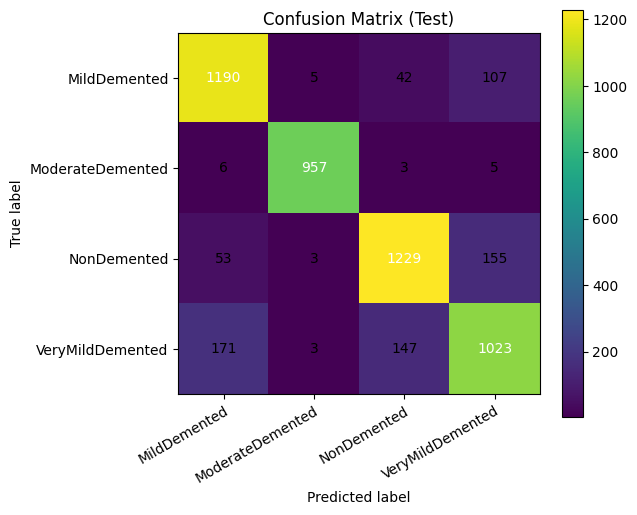

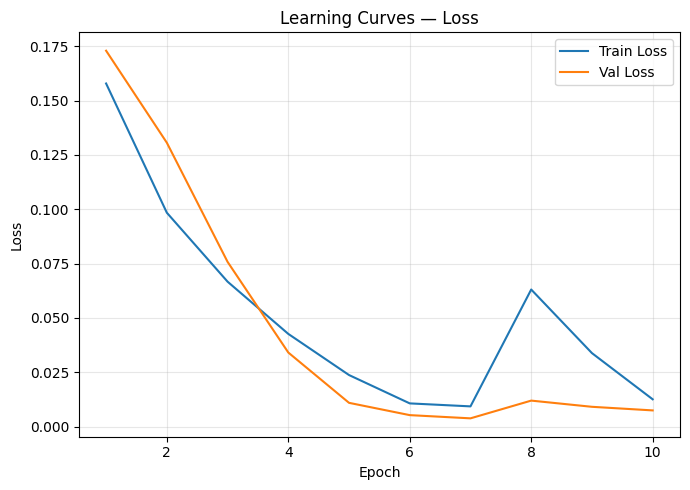

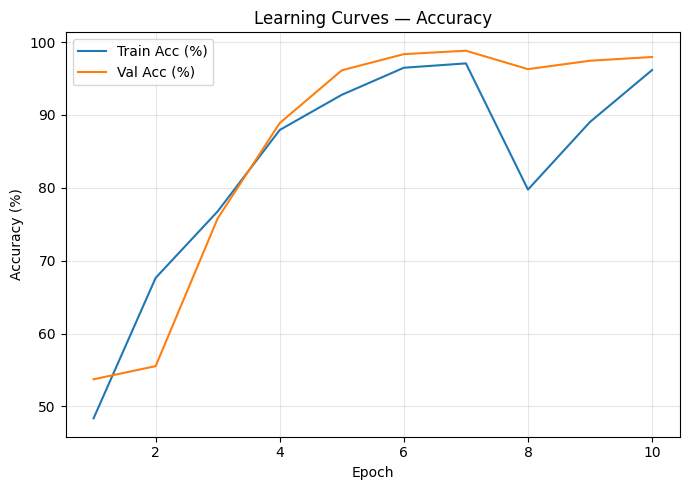

In [22]:
# ------- Cell H : evaluation & plot ----------


def _load_flexible_state_dict(model, state_dict):
    sd = dict(state_dict)
    sd.pop("n_averaged", None)
    if any(k.startswith("module.") for k in sd.keys()):
        sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
    model.load_state_dict(sd, strict=False)

ckpt = torch.load(best_ckpt, map_location=device)
_load_flexible_state_dict(model, ckpt["model"])

val_logits, yval = collect_logits(model, val_loader)
bias = tune_logit_bias(val_logits, yval, steps=np.linspace(-0.8,0.8,9), iters=2)

test_logits, ytest = collect_logits(model, test_loader)
logits_adj = test_logits.numpy() + bias
y_true = ytest.numpy()
y_pred = logits_adj.argmax(1)

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')
prec, rec, f1_each, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_names)), average=None, zero_division=0)

print("\n=== Test Metrics (SWA/EMA + TTA + bias) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Macro-F1:  {macro_f1:.4f}")
for i, cls in enumerate(class_names):
    print(f"  {cls:>18s}  P {prec[i]:.3f}  R {rec[i]:.3f}  F1 {f1_each[i]:.3f}")

probs = F.softmax(torch.from_numpy(test_logits.numpy()), dim=1).numpy()
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# plots
fig, ax = plt.subplots(figsize=(6.5, 5.5)); im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(class_names)), yticks=np.arange(len(class_names)),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label', xlabel='Predicted label', title='Confusion Matrix (Test)')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
thr = cm.max()/2 if cm.max()>0 else 0.5
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > thr else "black")
plt.tight_layout(); plt.show()

# --- Learning Curves: Loss ---
epochs = np.arange(1, len(history['train_loss'])+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves — Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Learning Curves: Accuracy ---
plt.figure(figsize=(7,5))
plt.plot(epochs, np.array(history['train_acc'])*100, label='Train Acc (%)')
plt.plot(epochs, np.array(history['val_acc'])*100, label='Val Acc (%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curves — Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### UI

In [23]:
import gradio as gr
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torchvision.models import efficientnet_b0

# Load model
ckpt = torch.load("alz_effnet_best.pt", map_location="cpu")
model = efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(ckpt["classes"]))
model.load_state_dict(ckpt["model"])
model.eval()

class_names = ckpt["classes"]

# Preprocessing (same as training)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
preprocess = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Prediction function
def predict(img):
    img = Image.fromarray(img).convert("RGB")
    x = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).squeeze()
        pred_class = class_names[probs.argmax()]
    return f"✅ Prediction: {pred_class}"

# Gradio UI with Blocks (more aesthetic)
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        <h1 style='text-align: center; color: #2E86AB;'> Alzheimer MRI Classifier🧠</h1>
        <p style='text-align: center; color: #555;'>Upload an MRI scan to detect Alzheimer stage</p>
        """
    )

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="numpy", label="Upload MRI Image")
            predict_btn = gr.Button("🔍 Classify")
        with gr.Column():
            output_text = gr.Textbox(label="Result", interactive=False)

    predict_btn.click(fn=predict, inputs=image_input, outputs=output_text)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e245aa6c4f43960441.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
